<a href="https://colab.research.google.com/github/gtbook/gtsam-examples/blob/main/PlanarSLAMExample_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling from the posterior

In this example we re-re-create the planar SLAM example, and then explore three techniques to obtain samples from the posterior:

- sampling from the Gaussian **Laplace-approximation** provided by [Marginals](https://gtsam.org/doxygen/a04396.html);
- using the Gaussian as a proposal density for **importance sampling**;
- **Metropolis sampling** with the tangent-space Gaussian as proposal density.

The Laplace approximation is simply taking the inverse of the Hessian at convergence as the covariance matrix of a Gaussian density around the MAP estimate. The [Marginals](https://gtsam.org/doxygen/a04396.html) class provides efficient methods to calculate any joint marginal of this density. However, especially when using nonlinear measurements such as bearing or bearing-range measurements it is important to realize just how much of an approximation this is, as will be illustrated below.

In [1]:
%pip -q install gtbook  # also installs latest gtsam pre-release


Note: you may need to restart the kernel to use updated packages.


In [40]:
import math
from math import pi, sqrt
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtsam
import gtsam.utils.plot as gtsam_plot
from gtbook.display import show
from gtsam import Point2, Pose2, Rot2, noiseModel


## Setting up a non-linear SLAM Example

Below we re-create a similar factor graph as in `PlanarSLAMExample`:

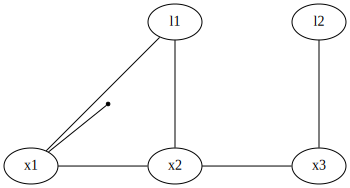

In [3]:
x1 = gtsam.symbol('x', 1)
x2 = gtsam.symbol('x', 2)
x3 = gtsam.symbol('x', 3)

graph = gtsam.NonlinearFactorGraph()
priorMean = Pose2(0.0, 0.0, 0.0)  # prior at origin
priorNoise = noiseModel.Diagonal.Sigmas([0.01, 0.01, math.radians(1)])
graph.add(gtsam.PriorFactorPose2(x1, priorMean, priorNoise))  # add directly to graph
odometry = Pose2(2.0, 0.0, 0.0)
odometryNoise = noiseModel.Diagonal.Sigmas([0.05, 0.02, math.radians(2)])
graph.add(gtsam.BetweenFactorPose2(x1, x2, odometry, odometryNoise))
graph.add(gtsam.BetweenFactorPose2(x2, x3, odometry, odometryNoise))

# Except, we use bearing only measurements for l1
l1 = gtsam.symbol('l', 1)
l2 = gtsam.symbol('l', 2)
bearingModel = noiseModel.Diagonal.Sigmas([0.1])
graph.add(gtsam.BearingFactor2D(x1, l1, Rot2(math.radians(45)), bearingModel))
graph.add(gtsam.BearingFactor2D(x2, l1, Rot2(math.radians(90)), bearingModel))

brNoise = noiseModel.Diagonal.Sigmas([math.radians(25), 0.1])
graph.add(gtsam.BearingRangeFactor2D(x3, l2, Rot2(math.radians(90)), 2, brNoise))

# Values with ground truth
truth = gtsam.Values()
truth.insert(x1, Pose2(0, 0, 0))
truth.insert(x2, Pose2(2, 0, 0))
truth.insert(x3, Pose2(4, 0, 0))
truth.insert(l1, Point2(2, 2))
truth.insert(l2, Point2(4, 2))

show(graph, truth, binary_edges=True)


As always, we can calculate and plot covariance ellipses which show the Laplace approximation graphically.

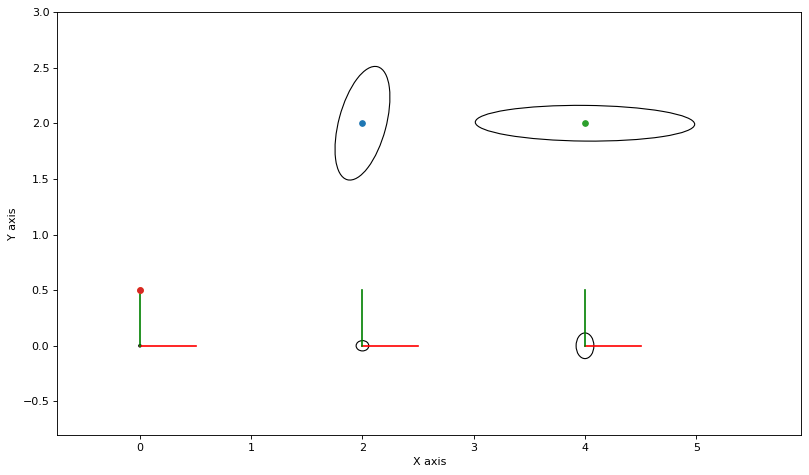

In [4]:
marginals = gtsam.Marginals(graph, truth)
def make_figure():
    plt.figure(0, figsize=(12, 7), dpi=80)
    for key in [x1, x2, x3]:
        gtsam_plot.plot_pose2(0, truth.atPose2(key), 0.5,
                            marginals.marginalCovariance(key))
    for key in [l1, l2]:
        gtsam_plot.plot_point2(0, truth.atPoint2(key), 0.5,
                            marginals.marginalCovariance(key))

    plt.axis('equal')
    plt.xlim([-0.8, 6])
    plt.ylim([-0.8, 3])

make_figure()

## The Laplace Approximation on the Manifold

To sample from the Laplace approximation we will use the corresponding Bayes Net, as it provides an efficient ancestral sampler. When we linearize at the ground truth and subsequently eliminate the resulting Gaussian factor graph, we obtain a Gaussian Bayes net, as shown below.

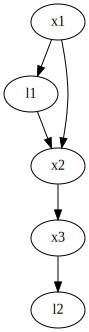

In [5]:
bayes_net = graph.linearize(truth).eliminateSequential()
show(bayes_net)

The following function implements ancestral sampling in an arbitrary Gaussian Bayes net. This is not yet implemented inside GTSAM for the fully general case, but will be soon.   It returns a dictionary of samples in the *tangent space* of each variable manifold, at the ground truth values.

In [6]:
def sample_gaussian(bn: gtsam.GaussianBayesNet, N):
    """ High performance ancestral sampling.
        TODO: move to GTSAM, yield VectorValues
    """
    sample = {}
    for i in reversed(range(bn.size())):
        # every node ~ exp(0.5*|R x + S p - d|^2)
        # calculate mean as inv(R)*(d - S p)
        node = bn.at(i)
        d = node.d()
        n = len(d)
        rhs = d.reshape(n, 1)
        key, *parents = node.keys()
        if len(parents) > 0:
            rhs = rhs - node.S() @ np.vstack([sample[p] for p in parents])
        # sample from conditional Gaussian
        invR = np.linalg.inv(node.R())
        sample[key] = invR @ (rhs + np.random.normal(size=(n, N)))
    return sample


The above creates samples in the *tangent space*, which we then need to upgrade to the non-linear manifold:

In [7]:
def perturb(tangent_samples:dict, values:gtsam.Values, s:int):
    vv = gtsam.VectorValues()
    for key in tangent_samples.keys():
        vv.insert(key, tangent_samples[key][:, s])
    return values.retract(vv)  # all variables updated

In [8]:
N = 5000
tangent_samples = sample_gaussian(bayes_net, N)
manifold_samples = [perturb(tangent_samples, truth, s) for s in range(N)]

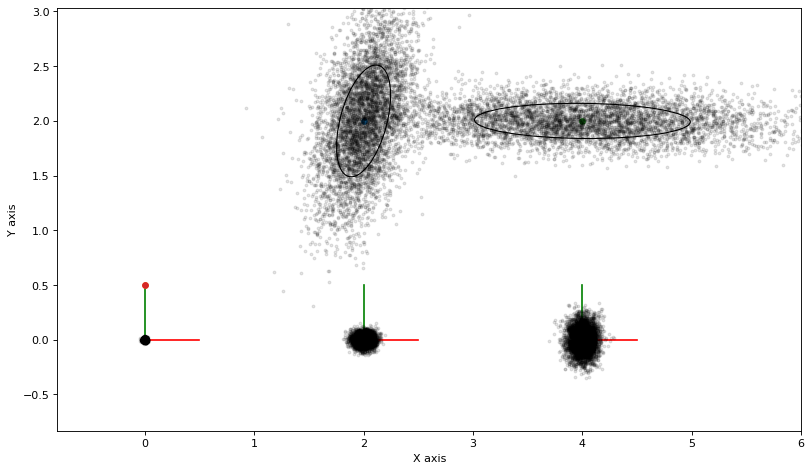

In [39]:
# Calculate and plot samples
make_figure()
for key in [x1, x2, x3]:
    for s, manifold_sample in enumerate(manifold_samples):
        point = manifold_sample.atPose2(key).translation()
        plt.plot(point[0], point[1], 'k.', markersize=5, alpha=0.1)
for key in [l1, l2]:
    point = truth.atPoint2(key).reshape(2, 1)
    plt.plot(point[0] + tangent_samples[key][0], point[1] +
             tangent_samples[key][1], 'k.', markersize=5, alpha=0.1)

## Importance Sampling

Below we use the same samples, but now use them to calculate importance weights. We then plot the *same* samples as above but with an opacity proportional to the importance weight. This is unfortunately *slow* with matplotlib.

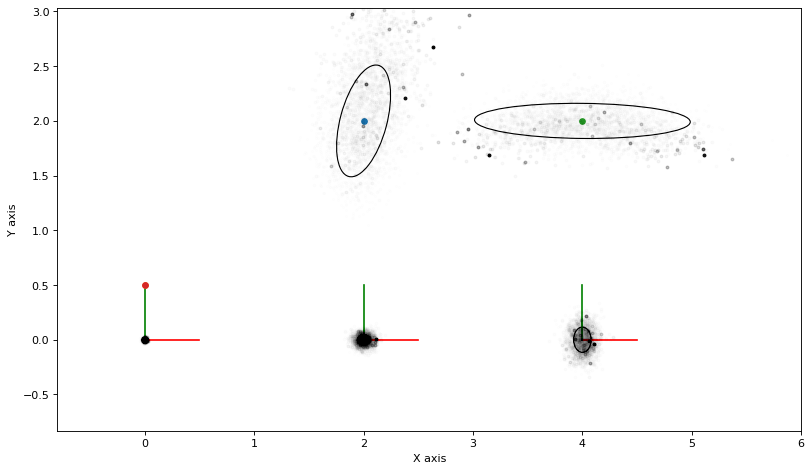

In [10]:
make_figure()

def weight(s, manifold_sample):
    # calculate error
    error = graph.error(manifold_sample)
    # calculate importance weight
    vv = gtsam.VectorValues()
    for key in tangent_samples.keys():
        vv.insert(key, tangent_samples[key][:, s])
    q = bayes_net.error(vv)
    return math.exp(q - error)


weights = np.array([weight(s, manifold_sample)
                   for s, manifold_sample in enumerate(manifold_samples)])
weights /= np.max(weights)

for key in [x1, x2, x3]:
    for s, manifold_sample in enumerate(manifold_samples):
        point = manifold_sample.atPose2(key).translation()
        plt.plot(point[0], point[1], 'k.', markersize=5, alpha=weights[s])
for key in [l1, l2]:
    for s, manifold_sample in enumerate(manifold_samples):
        point = manifold_sample.atPoint2(key)
        plt.plot(point[0], point[1], 'k.', markersize=5, alpha=weights[s])

 Note how the landmark densities are now definitely non-Gaussian: landmark $l_1$ is bearing only, and there is a "cone-like" extension of the density towards the top of the figure. Landmark $l_2$ is shaped like an arc, because of the uncertain bearing measurement coupled with a fairly good range measurement.
 
 The importance weight is calculated using the probability of the entire graph, for each perturbed manifold sample. Because the entire state is high-dimensional (in this case 16 dimensional) the variance of importance sampling will be high.
 You can actually *see* this in the plot, as there are a few high weight samples that dominate. Any expectation derived from these weighted samples will be rather poor in quality.

## Metropolis Sampling

A better approach is to use Markov Chain Monte Carlo (MCMC) sampling. As it happens, we can easily use the Bayes net sampler we created above to set up a Metropolis sampler:

  - Start with an initial estimate $x$
  - loop $N$ times:
    - propose $x' \sim q(x'|x)$ where we use the Bayes net density centered at $x$
    - calculate the acceptance ratio $a = p(x')/p(x)$
    - accept $x'$ as a (correlated) sample from $p(x)$ with probability $\min(1,a)$.

To implement the proposal density $q(x)$ we use the Gaussian density on the *tangent space* created at the ground truth, but use the *current* sample to generate a sample on the manifold. While we *could* create a new Laplace approximation for each new sample $x$ this would be expensive, and it is in fact not needed, as the proposal density is arbitrary. The intuition here is that the Laplace approximation is still much better than, say, an isotropic Gaussian as long as we are not too far the MAP solution.

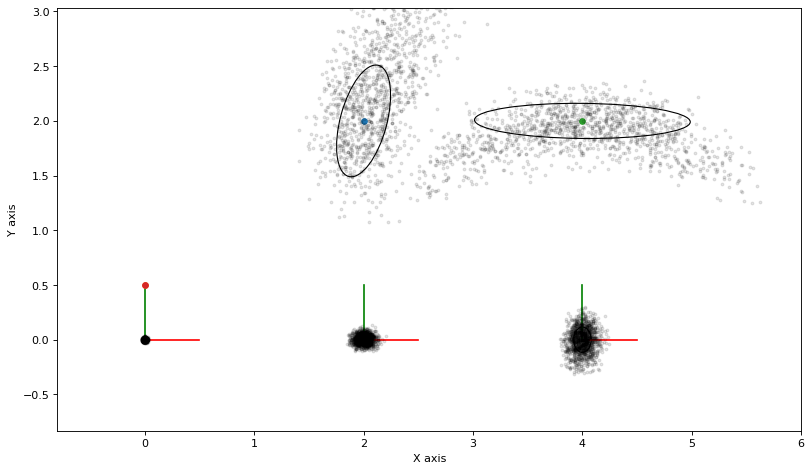

In [32]:
make_figure()
N = 20000
tangent_proposals = sample_gaussian(bayes_net, N)

def accept(log_a):
    """calculate acceptance, with some care to avoid overflow."""
    if log_a >= 0:
        return True
    if log_a < -10:
        return False
    return np.random.uniform() < math.exp(log_a)

# Start with an initial estimate x
x = perturb(tangent_proposals, truth, 0)
error_x = graph.error(x)

# loop N times:
for s in range(1, N):
    # propose p
    p = perturb(tangent_proposals, x, s)

    # Draw marginal sample if we accept:
    error_p = graph.error(p)
    log_a = error_x - error_p
    if accept(log_a):
        x = p
        error_x = error_p
        for key in [x1, x2, x3]:
            point = x.atPose2(key).translation()
            plt.plot(point[0], point[1], 'k.', markersize=5, alpha=0.1)
        for key in [l1, l2]:
            point = x.atPoint2(key)
            plt.plot(point[0], point[1], 'k.', markersize=5, alpha=0.1)

It is clear that MCMC is able to capture the shape of the posterior very nicely. 
The downside is that the samples were generated from a Markov chain and are *correlated*, so you have to be careful when using it.

## Computing Expectations

One way to use the MCMC samples is to approximate expected values under the posterior. In the example code we calculate the Monte Carlo expectations of $l_1$ and $l_2$, and they indeed agree with the MAP estimate. However, calculating the *distance* between those two landmarks is a nonlinear operation, and its Monte Carlo estimate deviates significantly from the estimate calculated at the ground truth solution. We also plot the histogram for the distance to show this more clearly.

MAP estimate for d12 = 2.0
MCMC estimate for d12 = 2.145091339642087


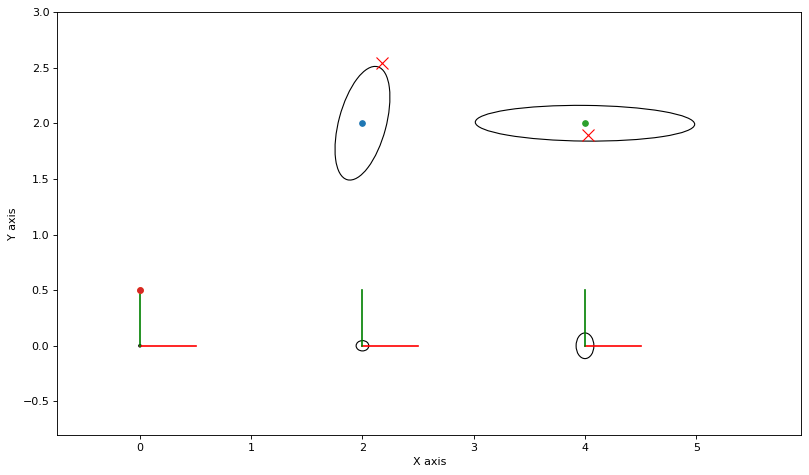

In [33]:
make_figure()

# Start with an initial estimate x
x = perturb(tangent_proposals, truth, 0)
error_x = graph.error(x)
l1_sample, l2_sample = x.atPoint2(l1), x.atPoint2(l2)
d12_sample = np.linalg.norm(l2_sample - l1_sample)

# Set up data structures to calculate posterior expectations
sums = {}
d12_samples = [d12_sample]
sums = {1:l1_sample, 2:l2_sample, 3:d12_sample}
num_accepted = 1

# loop N times:
for s in range(1, N):
    # propose p
    p = perturb(tangent_proposals, x, s)

    # Draw marginal sample if we accept:
    error_p = graph.error(p)
    log_a = error_x - error_p
    if accept(log_a):
        x = p
        error_x = error_p
        l1_sample, l2_sample = x.atPoint2(l1), x.atPoint2(l2)
        d12_sample = np.linalg.norm(l2_sample - l1_sample)

        # Update data structure
        d12_samples.append(d12_sample)
        sums[1] += l1_sample
        sums[2] += l2_sample
        sums[3] += d12_sample
        num_accepted += 1


for key in [1,2]:
    point = sums[key] / num_accepted
    plt.plot(point[0], point[1], 'rx', markersize=10)

print(f"MAP estimate for d12 = {np.linalg.norm(truth.atPoint2(l2)-truth.atPoint2(l1))}")
print(f"MCMC estimate for d12 = {np.linalg.norm((sums[3])/num_accepted)}")

We see that the Monte Carlo expectations for $l_1$ and $l_2$ do *not* agree with a MAP estimate, which is completely expected: the mean and mode of a density typically do not coincide. In addition, the Monte Carlo for their distance also does not agree. We plot the histogram of distance samples below, which is clearly non-Gaussian:

In [34]:
print(f"Histogram for {len(d12_samples)} |l2-l1| samples")
px.histogram(d12_samples)

Histogram for 1461 |l2-l1| samples


Finally, note that the correct MC expectation differs from taking the distance between the MCMC estimates, as distance is nonlinear:

In [35]:
print(f"Incorrect estimate for d12 = {np.linalg.norm((sums[2]-sums[1])/num_accepted)}")

Incorrect estimate for d12 = 1.964572719571093


Finally, please know that all of these are estimates, and have considerable variance. You can re-run the above code a few times to get an idea of the variance.